In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.edgetpu import make_interpreter
from matplotlib import pyplot as plt
import cv2 
%matplotlib inline

In [2]:
# Load TFLite model and allocate tensors.
model_name = "yolov5.tflite"
interpreter = make_interpreter(model_name, device=':0')
interpreter.allocate_tensors()



In [3]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

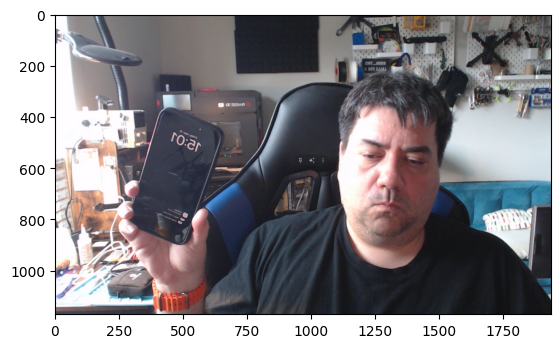

In [4]:
# img = Image.open('table.jpg')
img = Image.open('room2.png')

# max_dim = max(img.width, img.height)
# padded = Image.new(img.mode, (max_dim,max_dim), 'black')
# padded.paste(img,(0,0))
# img=padded

plt.imshow(img)

In [5]:
def process_frame(img, input_details, output_details, font):
    input_shape = input_details[0]['shape']
    #data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS), dtype=np.float32)
    data = cv2.resize(img, input_shape[1:3], interpolation = cv2.INTER_LANCZOS4).astype(np.float32)
    data /= 255.0
    data = data[np.newaxis,...]
    common.set_input(interpreter, data[...,:3])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]['index']).squeeze(0)
    boxes = result[...,0:4]
    boxes[...,0]*= img.shape[1]
    boxes[...,1]*= img.shape[0]
    boxes[...,2]*= img.shape[1]
    boxes[...,3]*= img.shape[0]
    scores = result[...,4:5].squeeze()
    selected = tf.image.non_max_suppression(
        boxes,
        scores,
        100,
        iou_threshold=0.2,
        score_threshold=0.3
    )
    draw_img = Image.fromarray( img)
    drawing = ImageDraw.Draw(draw_img)
    #f = ImageFont.truetype('Courier New.ttf',20)
    
    for ix in selected:
        res = result[ix,:]
        xywh = boxes[ix,:4]
        conf = res[5:]*res[4:5]
        clas = np.argmax(conf)
        #print(xywh, conf[clas], clas, classes[clas])
     
        drawing.rectangle([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2, xywh[0]+xywh[2]/2, xywh[1]+xywh[3]/2],
                          outline='green',width=3)
        drawing.text([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2],fill='white', 
                     stroke_width=3, stroke_fill='black',font=font,  text=f'{classes[clas]} @ {conf[clas]*100:.1f}%')
    return draw_img

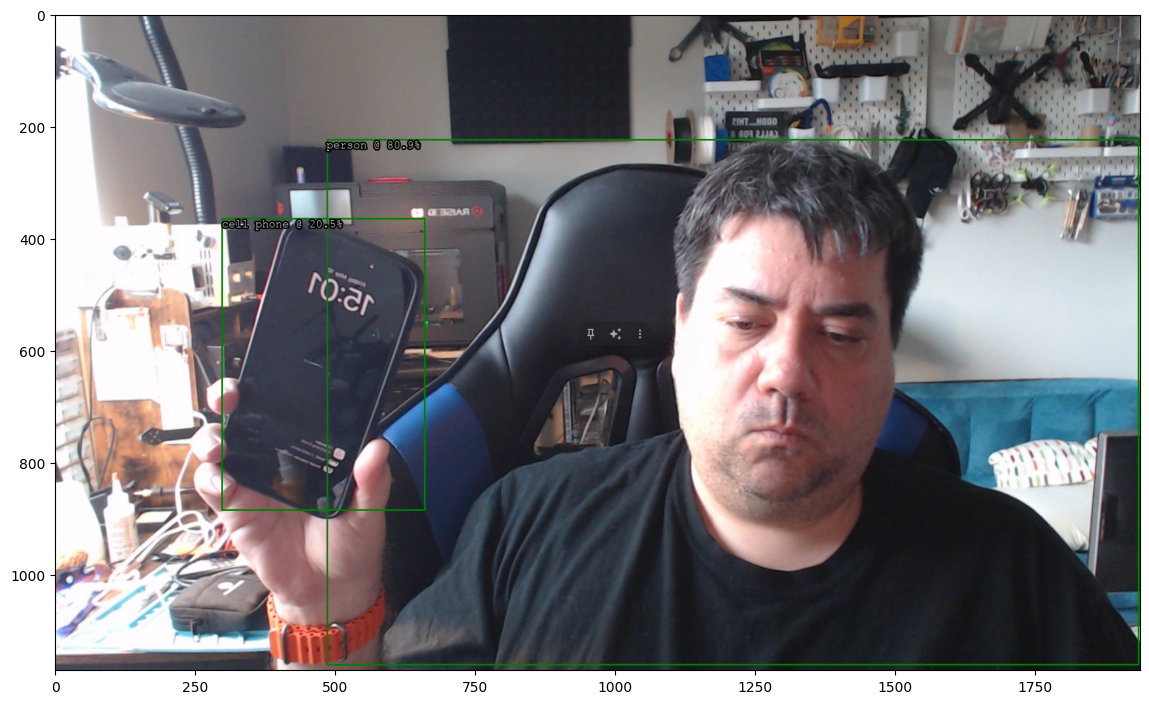

In [6]:
f = ImageFont.truetype('Courier New.ttf',20)

draw_img = process_frame(np.asarray(img), input_details, output_details, f)
plt.figure(figsize=(14,10))
plt.imshow(draw_img)

In [7]:
vid = cv2.VideoCapture(0)

out = cv2.VideoWriter('out.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, (640,480))
i = 0
while i< 3: 
    i+=1
    ret, vf = vid.read()
    if not ret:
        break
    frame = cv2.cvtColor(vf, cv2.COLOR_BGR2RGB)
    draw_img = process_frame(frame, input_details, output_details, f)
    out.write(np.asarray(draw_img))

out.release()
vid.release()